In [1]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle

In [2]:
class ThompsonSampling:
    def __init__(self, contents_ctr):
        """
        contents_ctr : [[0.1, 0.3, 0.3,0.1, ],[0.55, 0.9, 0.7],[0.8, 0.3, 0.4, 0.1]]
        """
        self.length = sum(len(ctr) for ctr in contents_ctr)
        self.gt = np.concatenate(contents_ctr)
        self.split(contents_ctr)
        
    def split(self, contents_ctr):
        contents_ctr = [np.array(c) for c in contents_ctr]
        self.contents_ctr = contents_ctr[0]
        self.norm_contents_ctr = self.normalize(self.contents_ctr)
        self.cans_ctr = contents_ctr[1:]
        
    def initalize(self):
        self.candidates = [*range(len(self.contents_ctr))]
        self.time_decays = {i:1 for i in range(self.length)}
        self.cluster_idx = [len(self.contents_ctr)]
        self.selected = [0]*len(self.candidates)
        
    def normalize(self, ctr):
        return ctr / sum(ctr)
    
    def cluster_decay(self):
        pass
        
    def time_decay(self):
        for i in range(len(self.contents_ctr)):
            self.time_decays[i] += 1
            
    def updated_arms(self):
        pass
    
    def add_new_cluster(self):
        pass

    def run(self, iteration = 100):
        self.initalize()
        
        grid_size = 3
        x = 0
        ploted = 0
        fig, ax = plt.subplots(grid_size, grid_size, figsize = (8,6))
        sec = int(iteration/grid_size)
        circle = cycle(range(grid_size))
        
        for i in range(iteration):
            
            self.updated_arms(i)
            
            if i % (sec//grid_size) == 0:
                y = next(circle)
                ax[x,y].bar(self.candidates, self.selected)

                if x == 0:
                    ax[x,y].set_title(f"{i}'th iter")
                else:
                    ax[x,y].set_title(f"{x+1}'th cans added {i}'th iter")
                    
                ploted += 1
                if ploted * (x+1) == grid_size**2:
                    break
                if ploted == grid_size:
                    x += 1
                    ploted = 0
                    self.add_new_cluster()
                    
        print(self.norm_contents_ctr)
        selected = np.array(self.selected)
        print(selected/sum(selected))
        plt.show()

### Dirichlet TS

In [5]:
class DirichletThompsonSampling(ThompsonSampling):
    def __init__(self, contents_ctr):
        super().__init__(contents_ctr)
        self.prior = np.ones_like(self.contents_ctr)

    def cluster_decay(self, updated_prior):
        curr_cluster = 0
        cluster_decay_factor= pow(10., len(self.cluster_idx))

        for item in range(len(updated_prior)):

            if item >= self.cluster_idx[curr_cluster]:
                cluster_decay_factor /= 10.
                curr_cluster += 1

            updated_prior[item] /= self.time_decays[item] * cluster_decay_factor
            
        return updated_prior
    
    def draw(self, prior):
        recommend = np.random.dirichlet(prior, 1)
        res = recommend[0].argsort()[::-1]
        
        return res
            
    def updated_arms(self, iteration, topk = 3):
        updated_prior = np.copy(self.prior)
        
        self.cluster_decay(updated_prior)
        
        res = self.draw(updated_prior)         
        for k in range(topk):
            self.selected[res[k]] += 1

        click = np.random.choice(self.candidates, p = self.norm_contents_ctr)
        self.prior[click] += 1

        self.time_decay()
        
        if iteration%10000 == 0:
            print('topk : ', res)
    
    def add_new_cluster(self):
        candidates = self.cans_ctr.pop(0)
        self.contents_ctr = np.concatenate([self.contents_ctr, candidates])
        self.prior = np.concatenate([self.prior, np.ones_like(candidates)])
        self.selected = np.concatenate([self.selected, np.zeros_like(candidates)])
        self.candidates = list(range(len(self.contents_ctr)))
        self.norm_contents_ctr = self.normalize(self.contents_ctr)
        self.cluster_idx.append(len(self.contents_ctr))

#### res

topk :  [0 1 3 2]
topk :  [1 2 0 3]
topk :  [1 3 2 0]
topk :  [5 4 6 2 1 3 0]
topk :  [4 5 6 2 1 3 0]
topk :  [5 4 6 0 2 3 1]
topk :  [ 4  8  7  9  6  2  5 10  3  1  0]
topk :  [ 9  7  8  4 10  5  6  3  2  1  0]
topk :  [ 6  5  7  8  9  4 10  3  2  1  0]
[0.02197802 0.06593407 0.06593407 0.02197802 0.12087912 0.1978022
 0.15384615 0.17582418 0.06593407 0.08791209 0.02197802]
[0.05548493 0.09886488 0.09937488 0.05581493 0.12173985 0.14708982
 0.13460983 0.10916611 0.06822741 0.08413489 0.02549247]


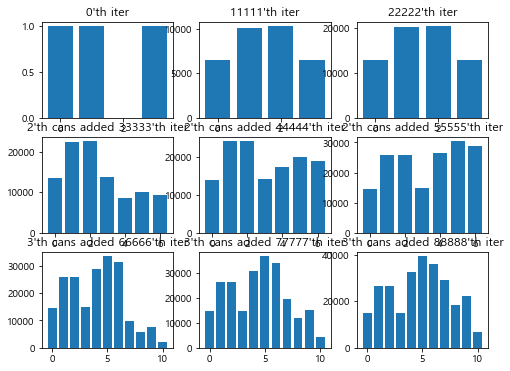

In [6]:
ts = DirichletThompsonSampling(contents_ctr = 
                      [
                        [0.1, 0.3, 0.3,0.1,],
                        [0.55, 0.9, 0.7],
                        [0.8, 0.3, 0.4, 0.1]
                      ])
ts.run(100000)

### Beta TS

In [3]:
class BetaThompsonSampling(ThompsonSampling):
    def __init__(self, contents_ctr):
        super().__init__(contents_ctr)
        self.alpha, self.beta = np.ones_like(self.contents_ctr), np.ones_like(self.contents_ctr)

    def cluster_decay(self, updated_alpha, updated_beta):
        curr_cluster = 0
        cluster_decay_factor = pow(10., len(self.cluster_idx))

        for item in range(len(updated_alpha)):

            if item >= self.cluster_idx[curr_cluster]:
                cluster_decay_factor /= 10.
                curr_cluster += 1

            updated_alpha[item] /= self.time_decays[item] * cluster_decay_factor
            updated_beta[item] /= self.time_decays[item] * cluster_decay_factor
            
        return updated_alpha, updated_beta
    
    def draw(self, alpha, beta):
        score = []
        for a,b in zip(alpha, beta):
            reward = np.random.beta(a,b)
            score.append(reward)
            
        return np.array(score).argsort()[::-1]
            
    def updated_arms(self, iteration, topk = 3):
        updated_alpha = np.copy(self.alpha)
        updated_beta = np.copy(self.beta)
        self.cluster_decay(updated_alpha, updated_beta)

        res = self.draw(updated_alpha, updated_beta)
        for k in range(topk):
            self.selected[res[k]] += 1

        click = np.random.choice(self.candidates, p = self.norm_contents_ctr)
        for item in range(len(self.contents_ctr)):
            if item == click:
                self.alpha[item] += 1
            else:
                self.beta[item] += 1

        self.time_decay()
        
        if iteration%10000 == 0:
#             print('gt / expexted')
#             for gt, a,b in zip(self.contents_ctr, self.alpha, self.beta):
#                 print(gt, a/(a+b))
            print('topk : ', res)
    
    def add_new_cluster(self):
        candidates = self.cans_ctr.pop(0)
        self.contents_ctr = np.concatenate([self.contents_ctr, candidates])
        self.alpha = np.concatenate([self.alpha, np.ones_like(candidates)])
        self.beta = np.concatenate([self.beta, np.ones_like(candidates)])
        self.selected = np.concatenate([self.selected, np.zeros_like(candidates)])
        self.candidates = list(range(len(self.contents_ctr)))
        self.norm_contents_ctr = self.normalize(self.contents_ctr)
        self.cluster_idx.append(len(self.contents_ctr))

#### res

topk :  [2 1 0 3]
topk :  [1 3 2 0]
topk :  [1 2 0 3]
topk :  [2 3 5 4 6 1 0]
topk :  [2 6 5 1 4 0 3]
topk :  [5 4 6 1 3 2 0]
topk :  [ 2  7  5  6 10  9  4  8  3  1  0]
topk :  [ 7  4  9  5  6  8 10  3  2  1  0]
topk :  [ 5  7  9 10  8  6  4  3  2  1  0]
[0.02197802 0.06593407 0.06593407 0.02197802 0.12087912 0.1978022
 0.15384615 0.17582418 0.06593407 0.08791209 0.02197802]
[0.06833241 0.14205732 0.14398482 0.07082616 0.10965361 0.14450232
 0.1228986  0.08132615 0.04362745 0.05640368 0.01638748]


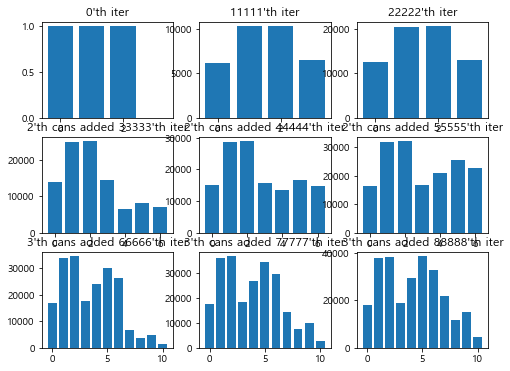

In [4]:
ts_b = BetaThompsonSampling(contents_ctr = 
                      [
                        [0.1, 0.3, 0.3,0.1,],
                        [0.55, 0.9, 0.7],
                        [0.8, 0.3, 0.4, 0.1]
                      ])
ts_b.run(100000)

In [273]:
# import scipy

# x = np.linspace(0, 1, 1002)[1:-1]

# for a,b in zip(ts_b.alpha, ts_b.beta):
#     dist = scipy.stats.beta(a,b)
#     dist_y = dist.pdf(x)
#     plt.plot(x,dist_y,label = f'({a},{b})')